In [1]:
import xarray as xr
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmocean.cm as cmo
#import functions as fun

In [2]:
#mods = fun.models()
mods = ['bcc-csm1-1','CanESM2','CCSM4','CNRM-CM5','CSIRO-Mk3-6-0','GFDL-CM3','GISS-E2-R','HadGEM2-ES','inmcm4','IPSL-CM5A-LR','MIROC-ESM','MIROC5','MRI-CGCM3','NorESM1-M']

In [17]:
mpl.rcParams['xtick.labelsize']       = 9
mpl.rcParams['ytick.labelsize']       = 9
mpl.rcParams['lines.linewidth']       = 2.
mpl.rcParams['axes.labelsize']        = 9
#mpl.rcParams['axes.labelweight']      = 'bold'
mpl.rcParams['axes.titlesize']        = 9
mpl.rcParams['font.family']           = 'serif'
#mpl.rcParams['axes.titleweight']      = 'bold'
mpl.rcParams['figure.subplot.bottom'] = .01
mpl.rcParams['figure.subplot.top']    = .99
mpl.rcParams['figure.subplot.left']   = .01
mpl.rcParams['figure.subplot.right']  = .8
mpl.rcParams['figure.subplot.wspace'] = .05
mpl.rcParams['figure.subplot.hspace'] = .0
mpl.rcParams['figure.figsize']        = 7,2.5


cols = {}
cols['ocean'] = '.7'
cols['land'] = '.9'

In [4]:
#Get 1x1 degree grid
with xr.open_dataset('../rawdata/rsl_85_2090.nc') as ds:
    lon = ds['x'].values
    lat = ds['y'].values
    slr_md = ds['slr_md'].values

#Get fingerprints
with xr.open_dataset('../rawdata/fp_uniform/AIS.nc') as ds:
    lon05  = ds['x'].values
    lat05  = ds['y'].values
    fp05_a = ds['rsl'].values
with xr.open_dataset('../rawdata/fp_uniform/GrIS.nc') as ds:
    fp05_gr = ds['rsl'].values
fp05_gl = np.zeros((19,len(lat05),len(lon05)))
for r in range(1,20):
    with xr.open_dataset(f'../rawdata/fp_uniform/RGI_{r}.nc') as ds:
        fp05_gl[r-1,:,:] = ds['rsl'].values

#Convert to 1x1 degree grid
fp_a  = np.zeros((len(lat),len(lon)))
fp_gr = np.zeros((len(lat),len(lon)))
fp_gl = np.zeros((19,len(lat),len(lon)))

for i,ii in enumerate(lat):
    ig = np.argmin((ii-lat05)**2)
    for j,jj in enumerate(lon):
        jg = np.argmin((jj-lon05)**2)
        fp_a[i,j] = fp05_a[ig,jg]
        fp_gr[i,j] = fp05_gr[ig,jg]
        fp_gl[:,i,j] = fp05_gl[:,ig,jg]

In [5]:
def nanvar(var):
    vvar = np.nanvar(var,axis=0)
    vvar[np.isnan(slr_md)]=np.nan
    return vvar

In [6]:
def get_var(scen):
    with xr.open_dataset(f'../data/rsl/{mods[0]}_{scen}.nc') as ds:
        lon = ds['lon'].values
        lat = ds['lat'].values
    stdn = np.zeros((len(mods),len(lat),len(lon)))
    glac = np.zeros((len(mods),len(lat),len(lon)))
    gsmb = np.zeros((len(mods),len(lat),len(lon)))
    asmb = np.zeros((len(mods),len(lat),len(lon)))
    adyn = np.zeros((len(mods),len(lat),len(lon)))
    
    for m,model in enumerate(mods):
        with xr.open_dataset(f'../data/rsl/{model}_{scen}.nc') as ds:
            stdn[m,:,:] = np.nanmean(ds['stdn'][-20:,:,:].values,axis=0)
            glac[m,:,:] = np.nanmean(ds['glac'][-20:,:,:].values,axis=0)  
            gsmb[m,:,:] = np.nanmean(ds['gsmb'][-20:,:,:].values,axis=0)
            asmb[m,:,:] = np.nanmean(ds['asmb'][-20:,:,:].values,axis=0)
            adyn[m,:,:] = np.nanmean(ds['adyn'][-20:,:,:].values,axis=0)
            
    vstdn = nanvar(stdn)
    vglac = nanvar(glac)
    vgsmb = nanvar(gsmb)
    vasmb = nanvar(asmb)
    vadyn = nanvar(adyn)
    vslr = nanvar(stdn+glac+gsmb+asmb+adyn)
    
    return vstdn,vglac,vgsmb,vasmb,vadyn,vslr

In [7]:
def makeglobal(ax):
    ax.set_global()
    ax.add_feature(cfeature.LAND,color=cols['land'])
    ax.add_feature(cfeature.OCEAN,color=cols['ocean'])
    ax.outline_patch.set_visible(False)

/Users/erwin/miniconda2/envs/codep/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: Mean of empty slice
  del sys.path[0]
/Users/erwin/miniconda2/envs/codep/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: Mean of empty slice
  
/Users/erwin/miniconda2/envs/codep/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: Mean of empty slice
  from ipykernel import kernelapp as app
/Users/erwin/miniconda2/envs/codep/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: Mean of empty slice
  app.launch_new_instance()
/Users/erwin/miniconda2/envs/codep/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: Mean of empty slice
/Users/erwin/miniconda2/envs/codep/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: Degrees of freedom <= 0 for slice.
  


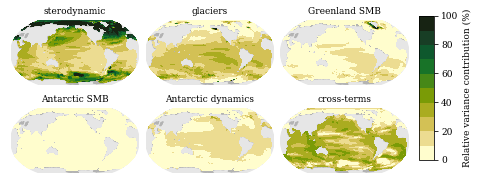

In [20]:
cmap = plt.get_cmap('cmo.thermal_r',16)
cmap2 = plt.get_cmap('cmo.speed',10)
vmax = 400
vmax2 = 100

for s,scen in enumerate(['rcp45']):

    fig = plt.figure()
    
    vstdn,vglac,vgsmb,vasmb,vadyn,vslr = get_var(scen)
    vres = vslr-vstdn-vglac-vgsmb-vasmb-vadyn
    
    ax = fig.add_subplot(2,3,1,projection=ccrs.Robinson(central_longitude=200))
    im2 = ax.pcolormesh(lon,lat,100.*vstdn/vslr,transform=ccrs.PlateCarree(),vmin=0,vmax=vmax2,cmap=cmap2)
    ax.set_title('sterodynamic')
    makeglobal(ax)
    
    ax = fig.add_subplot(2,3,2,projection=ccrs.Robinson(central_longitude=200))
    im2 = ax.pcolormesh(lon,lat,100.*vglac/vslr,transform=ccrs.PlateCarree(),vmin=0,vmax=vmax2,cmap=cmap2)
    ax.set_title('glaciers')
    makeglobal(ax)
    
    ax = fig.add_subplot(2,3,3,projection=ccrs.Robinson(central_longitude=200))
    im2 = ax.pcolormesh(lon,lat,100.*vgsmb/vslr,transform=ccrs.PlateCarree(),vmin=0,vmax=vmax2,cmap=cmap2)
    ax.set_title('Greenland SMB')
    makeglobal(ax)    
    
    ax = fig.add_subplot(2,3,4,projection=ccrs.Robinson(central_longitude=200))
    im2 = ax.pcolormesh(lon,lat,100.*vasmb/vslr,transform=ccrs.PlateCarree(),vmin=0,vmax=vmax2,cmap=cmap2)
    ax.set_title('Antarctic SMB')
    makeglobal(ax)
    
    ax = fig.add_subplot(2,3,5,projection=ccrs.Robinson(central_longitude=200))
    im2 = ax.pcolormesh(lon,lat,100.*vadyn/vslr,transform=ccrs.PlateCarree(),vmin=0,vmax=vmax2,cmap=cmap2)
    ax.set_title('Antarctic dynamics')
    makeglobal(ax)
    
    ax = fig.add_subplot(2,3,6,projection=ccrs.Robinson(central_longitude=200))
    im2 = ax.pcolormesh(lon,lat,100.*vres/vslr,transform=ccrs.PlateCarree(),vmin=0,vmax=vmax2,cmap=cmap2)
    ax.set_title('cross-terms')
    makeglobal(ax)

    cax = fig.add_axes([.82,.15,.03,.8])
    cb = plt.colorbar(im2,cax=cax)
    cb.set_label('Relative variance contribution (%)')    

    figname = f'posterplot_regvar_components_{scen}.png'

    plt.savefig(f'../figures/{figname}',dpi=600)
    plt.savefig(f'../../../writing/codependence/figures/{figname}')
    plt.show()
    plt.close()